# Essai de détermination des réformes possibles à partir de l'étude d'impact

On commence par initialiser le simulateur et importer des bibliothèques utiles.

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.EtudeImpact import EtudeImpact
import pylab as pl
from scipy import interpolate
from copy import deepcopy
import numpy as np

## Calcul de l'étude d'impact

In [2]:
simulateur = SimulateurRetraites()
etudeImpact = EtudeImpact(simulateur)
analyse = etudeImpact.calcule()

In [3]:
scenarios=[simulateur.scenario_central] # on se concentre sur le scenario 1,3% croissance

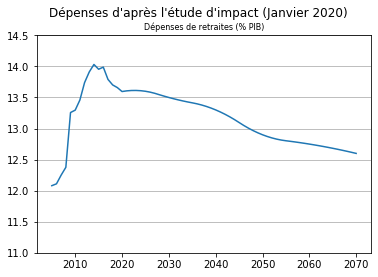

In [4]:
pl.suptitle("Dépenses d'après l'étude d'impact (Janvier 2020)");
analyse.graphique("Depenses", scenarios_indices = scenarios)
pl.grid(axis="y")
pl.ylim(bottom=11.0, top=14.5);

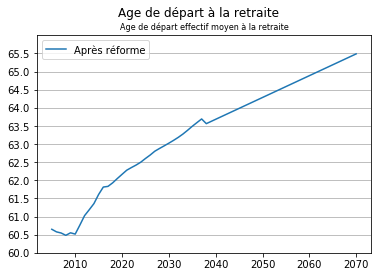

In [5]:
pl.suptitle("Age de départ à la retraite");
analyse.graphique("A",scenarios_indices=scenarios)
pl.legend(["Après réforme"])
pl.ylim(top= 66.0)
pl.yticks(np.arange(60.0, 66.0, 0.5))
pl.grid(axis="y")

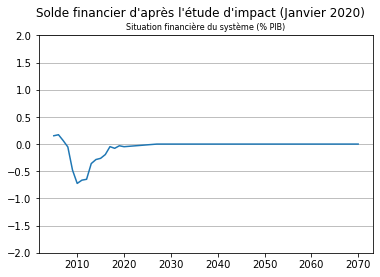

In [6]:
pl.suptitle("Solde financier d'après l'étude d'impact (Janvier 2020)");
analyse.graphique("S",scenarios_indices=scenarios)
pl.grid(axis="y")

## Calcul des couples (ages, pensions)

In [7]:
Acible=deepcopy(analyse.A)

En faisant une interpolation entre un départ à 62 ans et l'âge calculé plus haut, on balaye les possibilités de réalisations (toujours sous la contrainte système équilibré et taux de cotisation) et on trace l'évolution des courbes ages-pension en fonction des années.

In [8]:
annees = analyse.annees_standard
lx = [ [] for i in range(len(annees)) ]
ly = [ [] for i in range(len(annees)) ]

for x in pl.arange(0.0,1.001,0.01):

    for a in simulateur.annees_futures:
        Acible[simulateur.scenario_central][a] = 62.0*(1-x) + 70.0*x
    
    analyse = simulateur.pilotageParSoldeAgeDepenses(Scible=analyse.S, Acible=Acible, Dcible=analyse.Depenses)
    
    for i in range(len(annees)):
        lx[i].append( analyse.A[simulateur.scenario_central][annees[i]] )
        ly[i].append( analyse.P[simulateur.scenario_central][annees[i]] )

## Comparaison de l'étude d'impact avec tous les couples possibles

In [9]:
analyse = etudeImpact.calcule()

In [10]:
pensions_EI = []
ages_EI = []
for a in simulateur.annees_futures:
    ages_EI.append(analyse.A[simulateur.scenario_central][a])
    pensions_EI.append(analyse.P[simulateur.scenario_central][a])

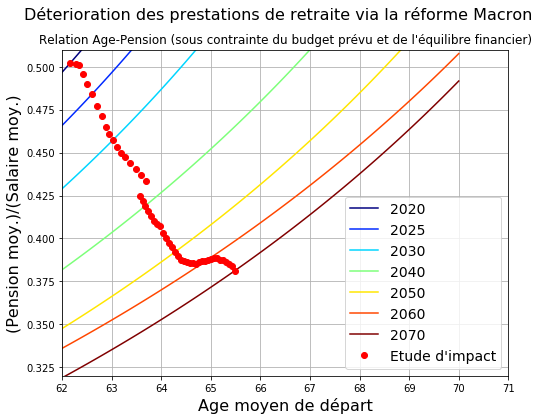

In [11]:
# pour avoir une jolie grille
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
major_ticks = pl.arange(62, 73, 1)
ax.set_xticks(major_ticks)
pl.grid()

colors = pl.cm.jet(pl.linspace(0,1,len(annees)))

pl.suptitle("Déterioration des prestations de retraite via la réforme Macron",fontsize=16)
pl.title("Relation Age-Pension (sous contrainte du budget prévu et de l'équilibre financier)")
pl.xlabel("Age moyen de départ",fontsize=16)
pl.ylabel("(Pension moy.)/(Salaire moy.)",fontsize=16)
pl.xlim(62.0, 71.0)
pl.ylim(0.32,0.51)

# trace les courbes
for i in range(len(annees)):
    pl.plot(lx[i],ly[i], label=str(annees[i]), color=colors[i])

pl.plot(ages_EI, pensions_EI,"ro", label="Etude d'impact")

pl.legend(fontsize=14);

pl.savefig("Article4/Simulation-Age-vs-pensions-vs-date.pdf")

En haut à gauche du graphique, c'est la pension rêvée du point de point de vue individuel: départ tôt et pension élevée. En bas à droite, c'est la pensée cauchemar.
En 2020, on a une pension rêvée. Avec le temps, les contraintes budgétaires choisies par le gouvernement font baisser la courbe age-pension vers le coin cauchemardesque.